# The global data journalists and their Github contributions: a case study from the Global Data Journalist Directory
- I scraped the [Global Data Journalist Directory](http://jplusplus.github.io/global-directory/) from github website. There are 217 so-called journalists in this directory and I get their locations through this dataset. Meanwhile, since these journalists' Github websites URL can be seen through this page, so we scrape all of their concontributions on an every day level to see how it changes through time.

## Preparation

In [1]:
import plotly.plotly as py
import pandas as pd
def city2country(t):
    if t == 'United States, Brooklyn (US-VA)':
        return 'United States'
    return t.split(', ')[-1]

def city2countrycode(t):
    df_c2c = pd.read_csv(
        'reference/country2code.csv',
        names=['country','country_code'])  #reference/country2code.csv是转换器文件
    dict_country2code = df_c2c.set_index(
                        'country').T  #country2code的dataframe轉化為字典
    return dict_country2code[t.split(', ')[-1]][0]  #将所有记者的country转化为code

def code2country(t):
    df_c2c = pd.read_csv(
        'reference/code&country.csv',
        names=['country_code','country'])  #reference/country2code.csv是转换器文件
    dict_code2country = df_c2c.set_index(
                        'country_code').T  #country2code的dataframe轉化為字典
    return dict_code2country[t][0]  #将所有记者的country转化为code

def paint_world_map_choropleth(title,locations,z,ztitle,filename):
    data = [ dict(
            type = 'choropleth',
            locations = locations,  #重要！國家代碼，可使用上面的方法把國家名轉化為代碼
            z = z,  #重要！數據
            text = text,  #重要！國家名，此處因為使用了dataframe的數據，因此所有項目都是一一對應關係
            colorscale = [[0,"rgb(0, 30, 155)"],[0.1,"rgb(15, 45, 165)"],[0.2,"rgb(30, 60, 175)"],
                          [0.3,"rgb(45, 75, 185)"],[0.4,"rgb(60, 90, 195)"],[0.5,"rgb(75, 105, 205)"],
                          [0.6,"rgb(90, 120, 215)"],[0.7,"rgb(115, 145, 225)"],[0.8,"rgb(140, 170, 235)"],
                          [0.9,"rgb(165, 195, 245)"],[1,"rgb(255, 255, 255)"]],  #深淺變化
            autocolorscale = False,  #深淺變化不符合審美，建議False
            reversescale = True,  #此項根據上面colorscale，設為True
            marker = dict(  #設置國界線
                line = dict (
                    color = 'rgb(180,180,180)',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = True,
                title = ztitle),  #重要！數據的单位
          ) ]

    layout = dict(
        title = title,  #設置標題
        geo = dict(
            showframe = False,  #設置有無地圖大邊框
            showcoastlines = False,  #設置有無海岸線
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = dict( data=data, layout=layout )
    return py.iplot( fig, validate=False, filename=filename)  #重要！设置网上存储的地图名（全部一样地图会被最后一个执行的覆盖掉）

df_s = pd.read_csv(  
    'reference/code&country.csv',names=['country_code','country']
)   #这是完整且不重复的国家表，用于需要分国家的地图中，用于存储每一个国家的数据，s代表store
df_gh = pd.read_csv(
    'reference/journalists-data-including-github-contributions.csv'
)   #这是记者们的2008年以来每天的github contribution
df_0d = df_gh.reindex(
    ['name','institution','city','github'],axis=1
)   #这是去除github contribution后的记者信息
df_0d['country'] = df_gh['city'].apply(city2country)
df_0d['country_code'] = df_gh['city'].apply(city2countrycode)  #将所有记者的country转化为code
df_0d['contribution_sum'] = df_gh.iloc[:,4:].aggregate('sum',axis=1).astype("int")
df_0d['name & country'] = df_0d['name'] + '(' + df_0d['country'] + ')'
    #这是转置后纯粹的时间信息

In [2]:
#2008以来各国contribution的总数

df_contribution_sum = pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='sum'
    ) #通过pivot_table获得journalist_count对应国家的contribution
#2008以来各国数据新闻记者的总数
df_journalist_amount = pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='count'
    ).rename(columns={'contribution_sum':'count'})   #通过pivot_table获得journalist_count对应记者数量
df_mean = pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='mean',
    ).rename(columns={'contribution_sum':'mean'}) 
df_max= pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='max',
    ).rename(columns={'contribution_sum':'max'}) 
df_code_country_data_c = df_s.join(df_contribution_sum, on='country_code').fillna(0) 
df_code_country_data_j = df_s.join(df_journalist_amount, on='country_code').fillna(0) 
df_code_country_data_r = df_s.join(df_mean, on = 'country_code').fillna(0) 
df_code_country_data_m = df_s.join(df_max, on = 'country_code').fillna(0) 

# df_code_country_data_j[df_code_country_data_j['journalist_count'] != 0].shape[0]
df_code_country_data=pd.merge(
    pd.merge(
        df_code_country_data_c, df_code_country_data_j, how='inner'
    ),df_code_country_data_r, how='inner'
)

# Which country has the largest number of data journalism in the Global Data Journalist Directory?
- In this section, there are more than 200 so-called data-journalists in this directory, about 80+ of who have Github, So that we can look into their contributions to see their behaviour and working habits:

In [123]:
#DJ世界分布
import plotly.plotly as py
import pandas as pd

df_geo = pd.read_csv('reference/geopy-raw.csv')

df_geo['text'] = df_0d['name'] + '<br>Institution:' + df_0d['institution'] + '<br>City:'\
+ df_0d['city'] + '<br>Contribution:' + df_0d['contribution_sum'].astype(str)

scl = [ [0,"rgb(0, 5, 62)"],[0.87,"rgb(40, 60, 190)"],[0.90,"rgb(70, 100, 245)"],\
    [0.93,"rgb(90, 120, 245)"],[0.96,"rgb(106, 137, 247)"],[0.99,"rgb(126, 157, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = df_geo['lon'],  #
        lat = df_geo['lat'],  #
        text = df_geo['text'],  #
        mode = 'markers',
        marker = dict(
            size = 10,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = df_0d['contribution_sum'],  #
            cmax = df_0d['contribution_sum'].max(),  #
            colorbar=dict(
                title="Contribution"
            )
        ))]

layout = dict(
        title = 'Map 1: Global Data Journalist Distribution<br>Source:\
                <a href="http://jplusplus.github.io/global-directory/">\
                Global Data Journalist Directory</a>',
        colorbar = True,
        geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='Map1*: Global Data Journalist Distribution' )

Most of the data journalist are living in North America and Europe. There is also a trend of DJ in South America.

In [122]:
locations = list(df_code_country_data_c['country_code'])
text = list(df_code_country_data_c['country'])
z = list(df_code_country_data_c['contribution_sum'])
ztitle = 'amount'
title = 'Map 2: Global Data Journalist Github Contribution<br>Source:\
                <a href="http://jplusplus.github.io/global-directory/">\
                Global Data Journalist Directory</a>'
filename = title.split('<br>')[0]

paint_world_map_choropleth(title,locations,z,ztitle,filename)

## Introduction
It is astonishing that in the map of overall Github contributions of one country, France and South Africa's color are very deep. And the U.S's advantage is not as obvious as it act in the map for the amount of DJ. 
- Why the contributions of American data journalists are relatively lower than journalists living in France and South - Africa? 
- Is that means data journalists in countries like South Africa are very productive in programming? 
I draw 4 bar maps to analyse these questions:

Text(0.5,1,'Chart 4: The Most Productive Journalists in globe')

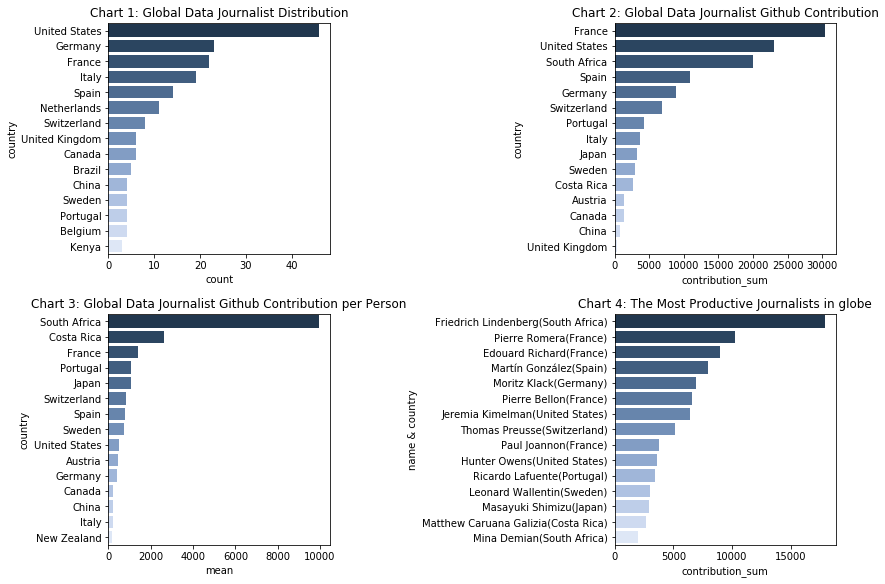

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2,constrained_layout=True,figsize = (12,8))
ax1 = sns.barplot(
    x='count',
    y='country',
    data=df_code_country_data_j.sort_values(
        by=['count'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[0,0])
ax1.set_title('Chart 1: Global Data Journalist Distribution', fontsize=12)

ax2 = sns.barplot(
    x='contribution_sum',
    y='country',
    data=df_code_country_data_c.sort_values(
        by=['contribution_sum'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[0,1])
ax2.set_title('Chart 2: Global Data Journalist Github Contribution', fontsize=12)

ax3 = sns.barplot(
    x='mean',
    y='country',
    data=df_code_country_data_r.sort_values(
        by=['mean'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[1,0])
ax3.set_title('Chart 3: Global Data Journalist Github Contribution per Person', fontsize=12)

ax4 = sns.barplot(
    x='contribution_sum',
    y='name & country',
    data=df_0d.sort_values(
        by=['contribution_sum'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[1,1])
ax4.set_title('Chart 4: The Most Productive Journalists in globe', fontsize=12)

## Indepth
As a result, we can get these 2 story point:
### Story point1: 
- In chart 1, U.S data journalists are the most in this diretory, almost the sum of the 2nd and 3rd one, which is German and France. However, the chart 2 shows that the contributions from the U.S lead not as significantly as the data journalists' amount from the U.S. Therefore, when we investigate the contribution per person in chart 3, the U.S's rank is only 9th. 
- I think it is because the media in the U.S have a higher degree of industrialization than in the other part of the world. The professional communicators don't need to program by themselves. Also, the workload and living expence in the U.S don't allow them to write and program simutanlously. This could be a research direction in future.

### Story point2: 
- In chart 3, we find that the ratio(contribution per person) of South Africa is dramatically higher than others. Actually if we check map 1, we will find that there are only 2 journalists in this directory. To be more generic, we find that there are a lot of 'super data journalists' outside the U.S in chart 4. Compared with the DJ in the U.S, the data journalists in South Africa and France have more integrated abilites in both media skills and data technologies. This is a interesting story point.

Global Data Journalist Distribution: 

# How the contributions of data journalists changes from 2008?

In [120]:
from matplotlib import pyplot as plt
import pandas as pd
from dateutil.parser import parse

df_d = df_gh.loc[:,'2018-10-31':'2008-01-01'].join(
    df_0d['country_code'].apply(code2country)
).groupby('country_code').aggregate('sum').T
df_d['dd'] = df_d.index
df_d['datetime'] = df_d['dd'].apply(parse)
df_d = df_d.set_index('datetime').resample('1D').aggregate('sum')
df_accumulate = df_d.T[df_d.sum() > 5000].T
for m in df_accumulate:
    for i in range(1,len(df_accumulate.index)):
        df_accumulate[m][i]+=df_accumulate[m][i-1]

df_d = df_gh.loc[:,'2018-10-31':'2008-01-01'].join(
    df_0d['country_code'].apply(code2country)
).groupby('country_code').aggregate('sum').T
df_d['dd'] = df_d.index
df_d['datetime'] = df_d['dd'].apply(parse)
df_d = df_d.set_index('datetime').resample('2M').aggregate('sum')
df_sum = df_d.T[df_d.sum() > 5000].T

df_e = df_gh.loc[:,'2018-10-31':'2008-01-01'].join(
    df_0d['country_code'].apply(code2country)
).groupby('country_code').aggregate('mean').T
df_e['dd'] = df_e.index
df_e['datetime'] = df_e['dd'].apply(parse)
df_e = df_e.set_index('datetime').resample('2M').aggregate('sum')
df_mean = df_e.T[df_d.sum() > 5000].T

Text(0.5,1,'Global Data Journalist Github Contribution (averaged by countries)')

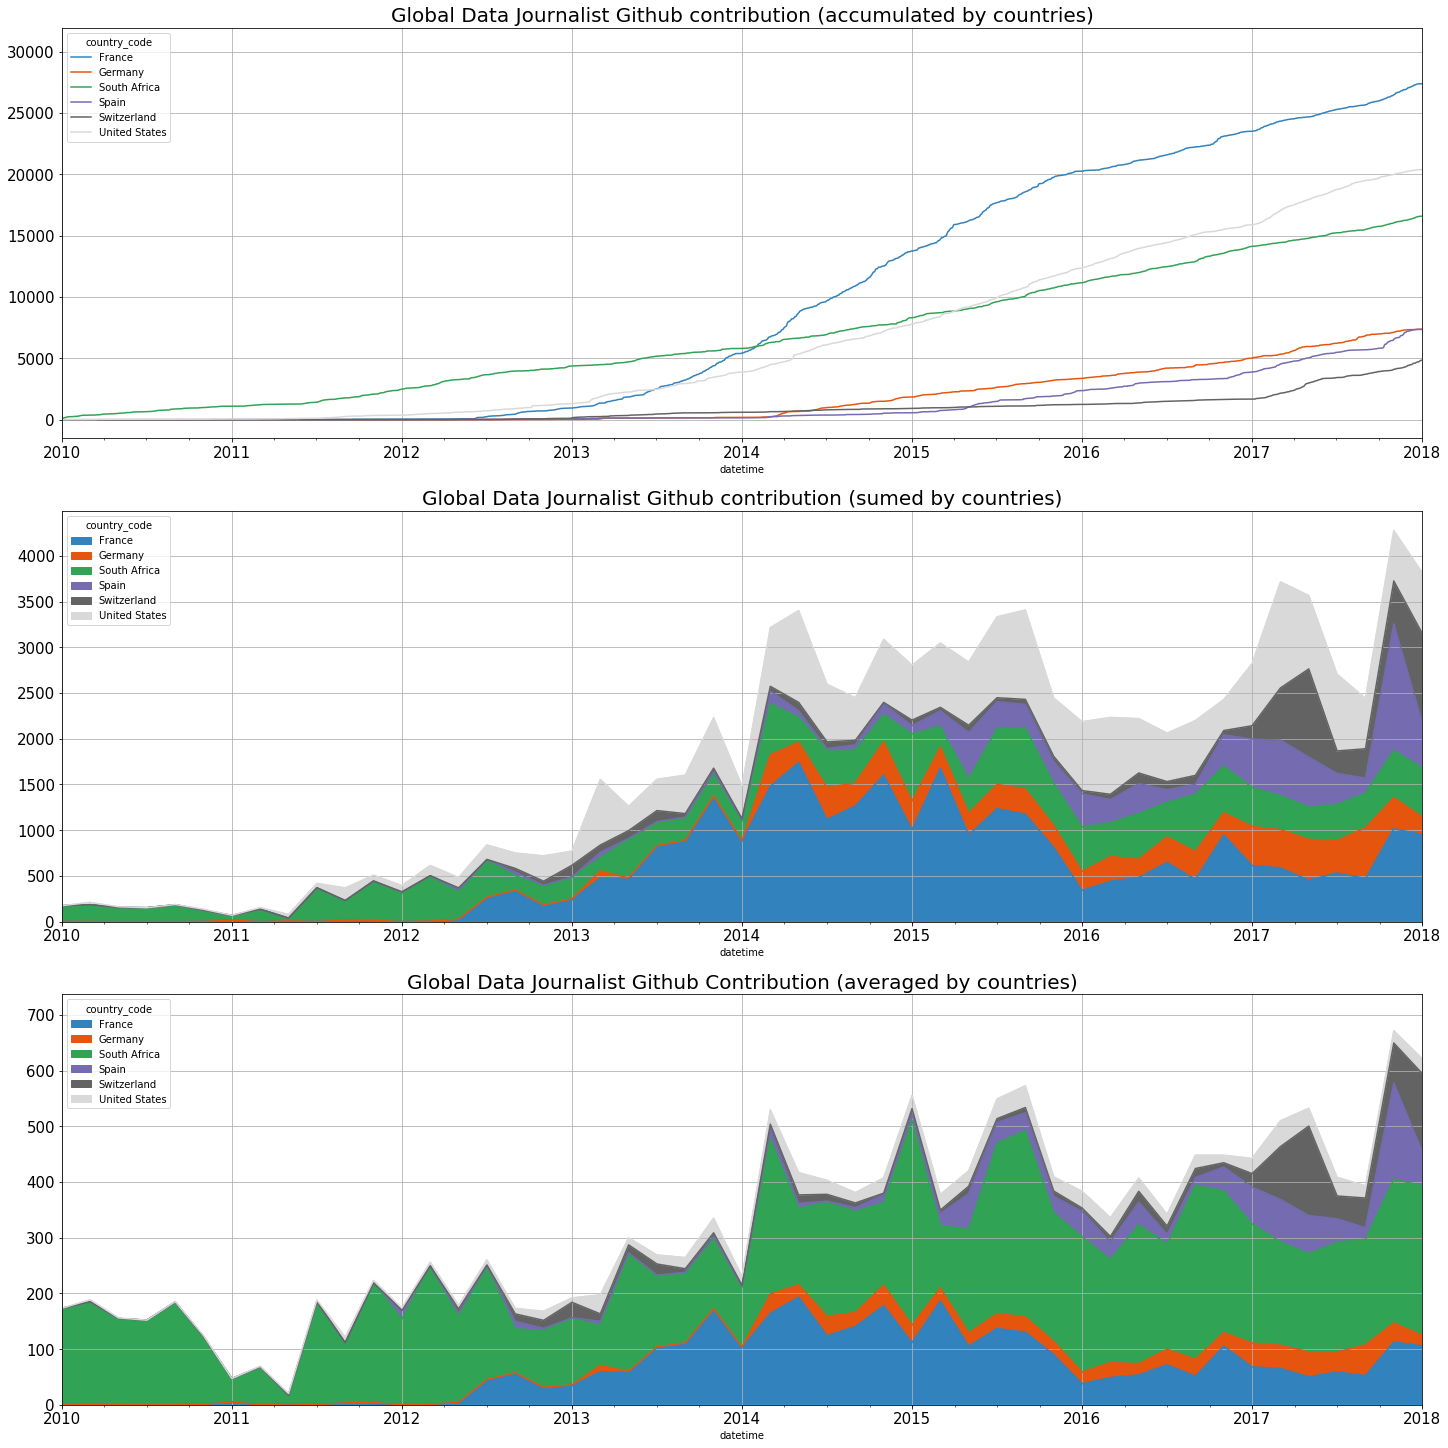

In [121]:
fig, axes = plt.subplots(nrows=3, ncols=1,constrained_layout=True)
ax0 = df_accumulate.plot(
    fontsize = 15,
    kind = 'line',
    grid = True,
    figsize = (20,20),
    colormap = 'tab20c',
    xlim = ('2010','2018'),
    ax=axes[0])
ax0.set_title('Global Data Journalist Github contribution (accumulated by countries)', fontsize=20)

ax1 = df_sum.plot(
    fontsize = 15,
    kind = 'area',
    grid = True,
    figsize = (20,20),
    colormap = 'tab20c',
    xlim = ('2010','2018'),
    ax=axes[1])
ax1.set_title('Global Data Journalist Github contribution (sumed by countries)', fontsize=20)

ax2 = df_mean.plot(
    fontsize = 15,
    kind = 'area',
    grid = True,
    figsize = (20,20),
    colormap = 'tab20c',
    xlim = ('2010','2018'),
    ax=axes[2])
ax2.set_title('Global Data Journalist Github Contribution (averaged by countries)', fontsize=20)

### Story point 3: 
- This area charts illustrate that in 2015-2016, the data journalism industry experienced a spring, then an inflation in 2016-2017. Recently, it seems that the DJ trend comes back again. From the line chart we find U.S, France and South Africa will be the next hotpoint. 

### Story point 4: 
- Also, We see around every year Xmas the journalists' contributions will decrease. Data journalists also need holiday. 